In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [2]:
from prj.config import DATA_DIR


BASE_PATH = DATA_DIR  / 'train'
train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(10)
])

In [3]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)]).collect()
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 1         ┆ 0.738489   ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999  ┆ 0.095504  │
│ 0       ┆ 0       ┆ 7         ┆ 2.965889   ┆ … ┆ 5.0        ┆ 0.703665   ┆ 0.216683  ┆ 0.778639  │
│ 0       ┆ 0       ┆ 9         ┆ -0.864488  ┆ … ┆ 0.099793   ┆ 2.109352   ┆ 0.670881  ┆ 0.772828  │
│ 0       ┆ 0       ┆ 10        ┆ 0.408499   ┆ … ┆ 1.225376   ┆ 1.114137   ┆ 0.775199  ┆ -1.379516 │
│ 0       ┆ 0       ┆ 14        ┆ -0.373387  ┆ … ┆ -5.0       ┆ -3.57282   ┆ -1.089123 ┆ -5.0      │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Responders

In [4]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

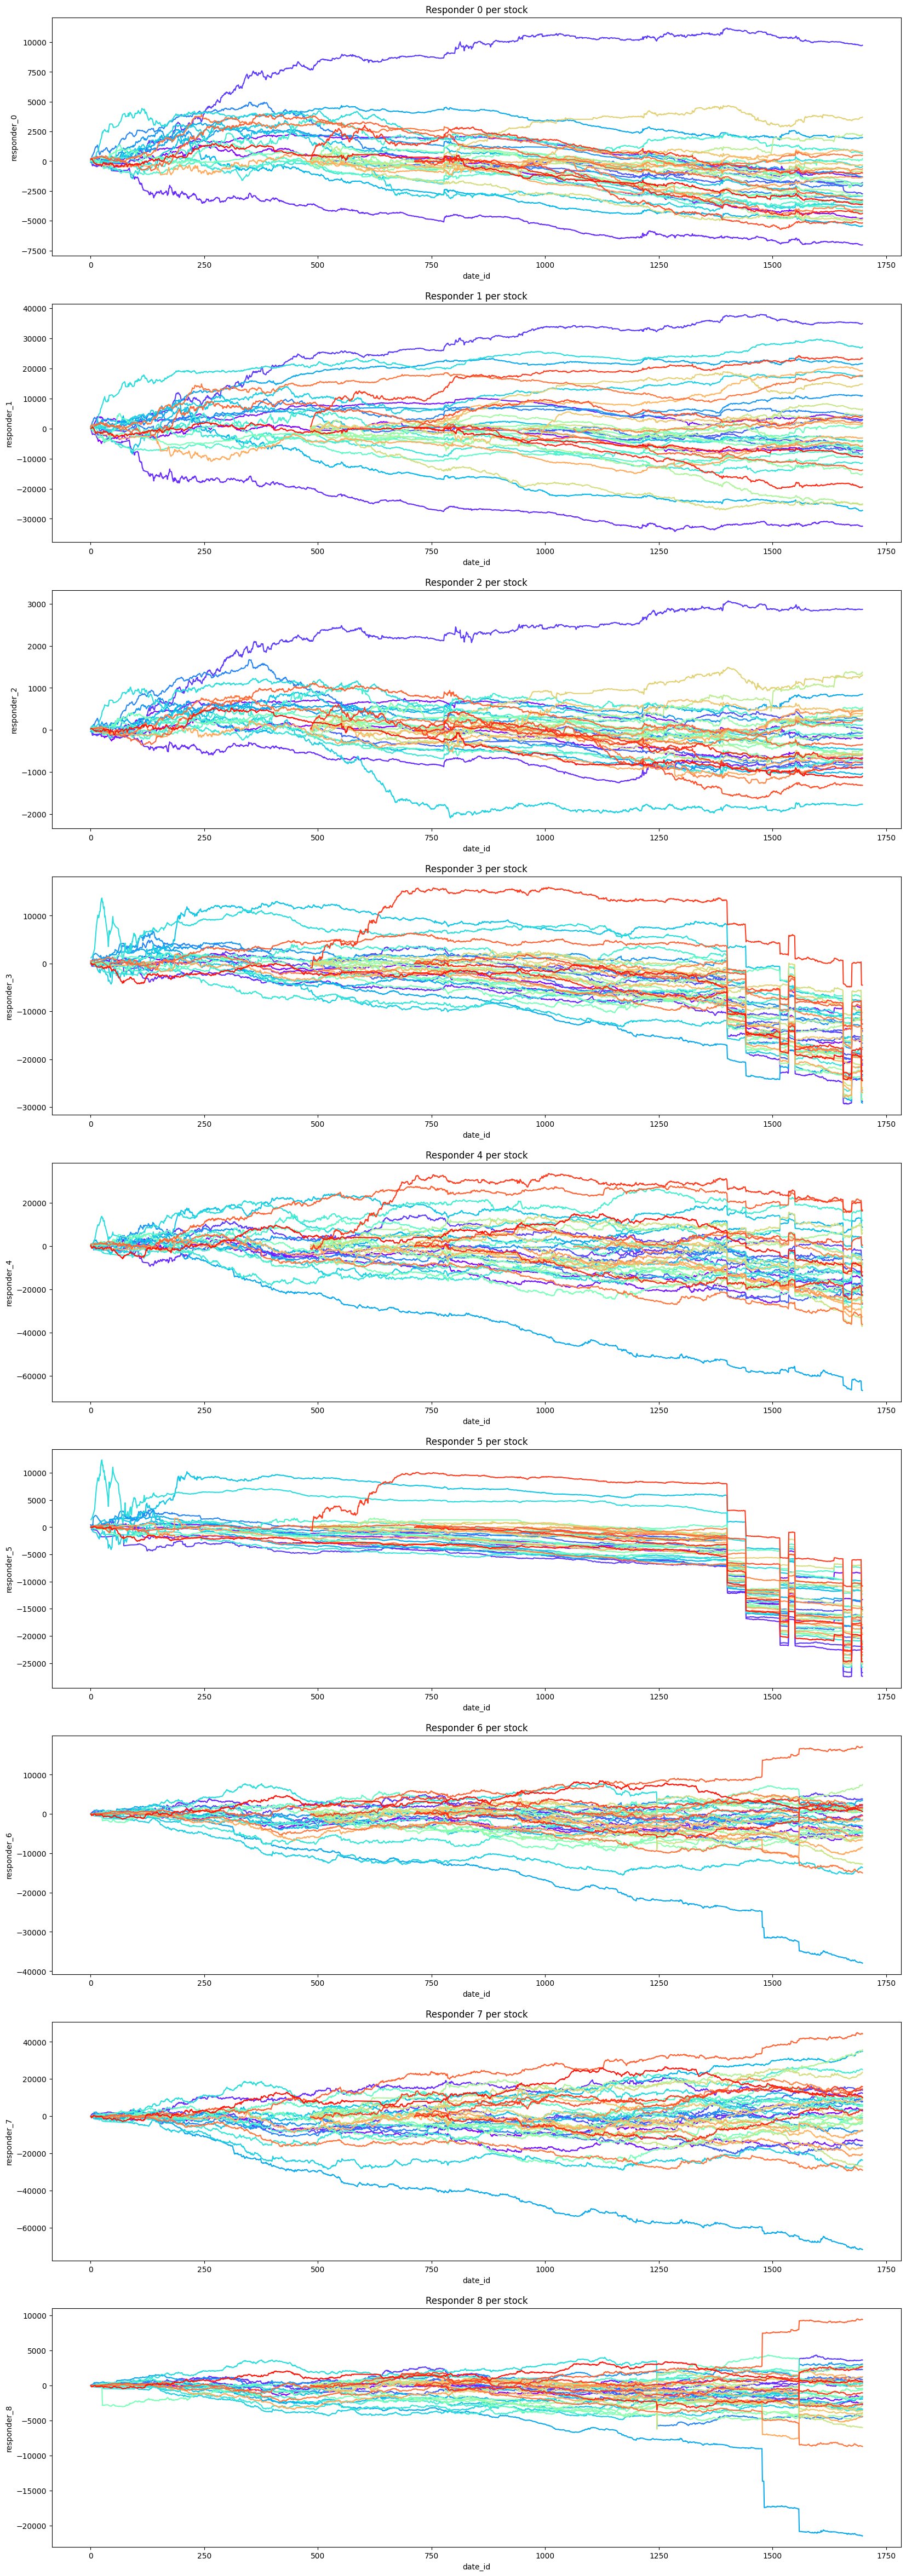

In [5]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum()).sort('date_id')

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [6]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum()).sort('date_id', 'time_id')
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 3.685916   ┆ 0.527153   ┆ … ┆ 1.210397   ┆ 2.128361  ┆ 0.199605  ┆ -4.368628 │
│ 0       ┆ 1       ┆ 2.756057   ┆ 1.237626   ┆ … ┆ 3.816604   ┆ 3.982676  ┆ 1.465504  ┆ 1.456441  │
│ 0       ┆ 2       ┆ 4.605119   ┆ 1.341283   ┆ … ┆ -0.031755  ┆ 3.996138  ┆ 0.478332  ┆ -1.939643 │
│ 0       ┆ 3       ┆ 4.51721    ┆ 1.413946   ┆ … ┆ 1.394032   ┆ 3.406353  ┆ 0.824257  ┆ -1.21198  │
│ 0       ┆ 4       ┆ -5.408631  ┆ -5.91932   ┆ … ┆ -7.591693  ┆ -0.471636 ┆ -0.144734 ┆ -4.422788 │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

<Axes: ylabel='Count'>

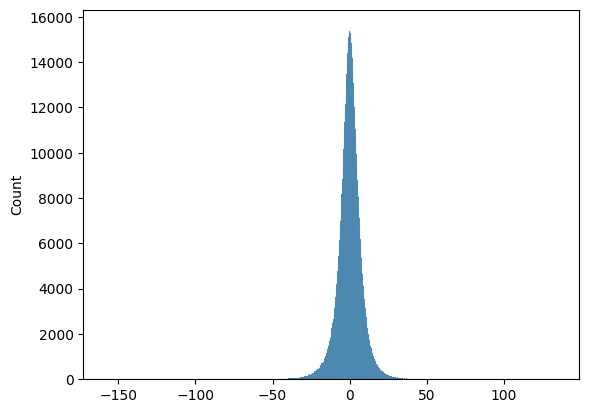

In [7]:
sns.histplot(time_responders['responder_6'].to_numpy())

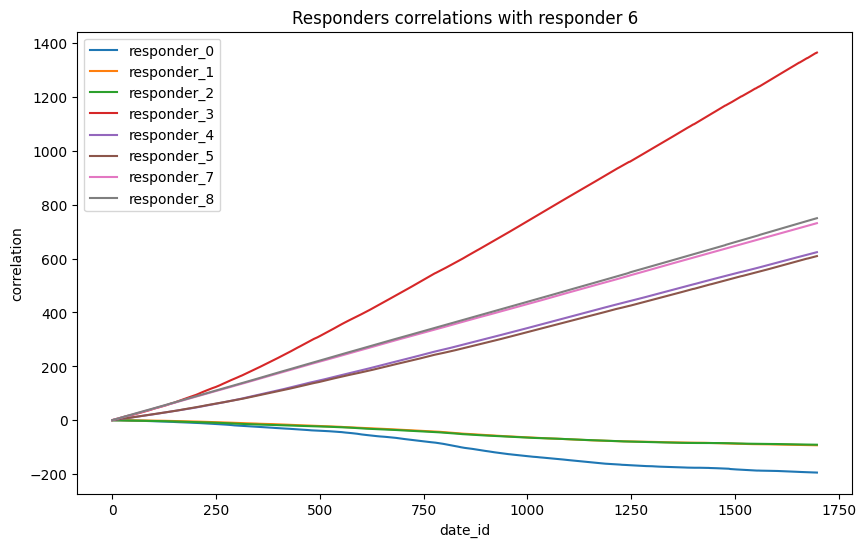

In [8]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}', 'responder_6') for i in range(9) if i != 6
).sort('date_id').with_columns(pl.col(f'responder_{i}').cum_sum() for i in range(9) if i != 6)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    if i != 6:
        ax.plot(daily_cumulative_correlations[f'responder_{i}'], label=f'responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Responders correlations with responder 6')
ax.legend()
plt.show()

# Lagged Responders

In [14]:
from prj.utils import reduce_mem_usage


agg_responders = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}').sum().alias(f'total_responder_{i}') for i in range(9)] + \
    [pl.col(f'responder_{i}').mean().alias(f'mean_responder_{i}') for i in range(9)]
).with_columns(pl.col('date_id').add(1))
agg_responders = reduce_mem_usage(agg_responders)
one_day_lagged_responders = responders.with_columns(pl.col('date_id').add(1))

In [15]:
responders = responders.join(agg_responders, on=['date_id', 'symbol_id'], how='left') \
    .join(one_day_lagged_responders, on=['date_id', 'time_id', 'symbol_id']) \
    .rename({f'responder_{i}_right': f'responder_{i}_lag_daily' for i in range(9)}) \
    .sort(['date_id', 'time_id', 'symbol_id'])
responders.head(5)

shape: (5, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1       ┆ 0       ┆ 1         ┆ 0.16938    ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999  ┆ 0.095504  │
│ 1       ┆ 0       ┆ 7         ┆ -1.926957  ┆ … ┆ 5.0        ┆ 0.703665   ┆ 0.216683  ┆ 0.778639  │
│ 1       ┆ 0       ┆ 9         ┆ 0.416857   ┆ … ┆ 0.099793   ┆ 2.109352   ┆ 0.670881  ┆ 0.772828  │
│ 1       ┆ 0       ┆ 10        ┆ -0.013016  ┆ … ┆ 1.225376   ┆ 1.114137   ┆ 0.775199  ┆ -1.379516 │
│ 1       ┆ 0       ┆ 16        ┆ -1.443583  ┆ … ┆ -1.593503  ┆ 0.84055    ┆ 0.246794  ┆ -0.101013 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

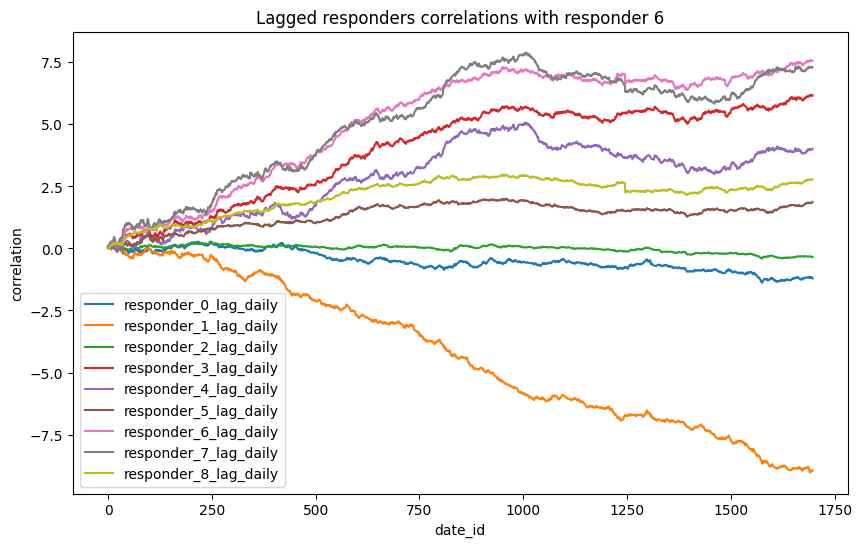

In [16]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}_lag_daily', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'responder_{i}_lag_daily').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'responder_{i}_lag_daily'], label=f'responder_{i}_lag_daily')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Lagged responders correlations with responder 6')
ax.legend()
plt.show()

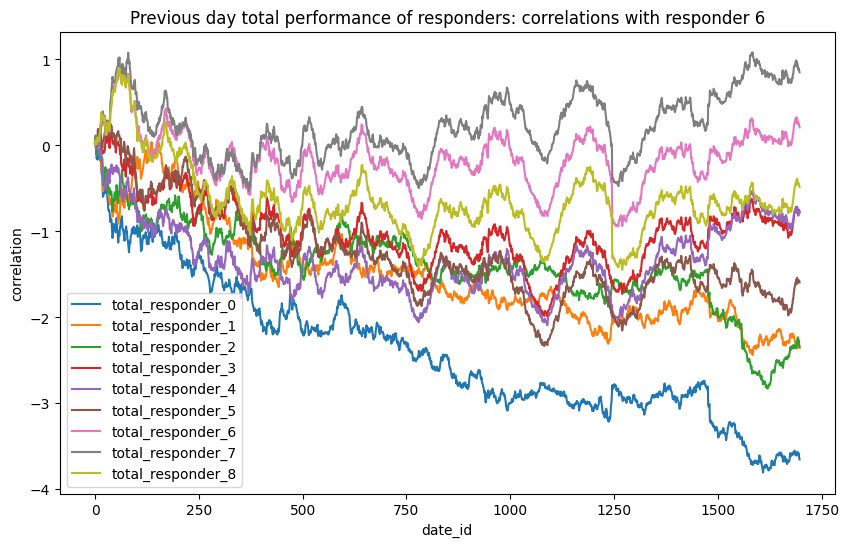

In [17]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'total_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'total_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'total_responder_{i}'], label=f'total_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day total performance of responders: correlations with responder 6')
ax.legend()
plt.show()

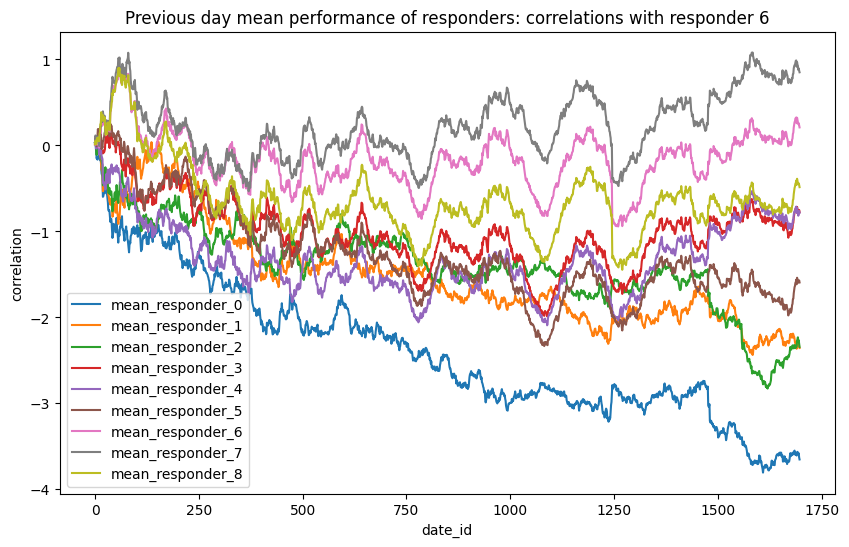

In [18]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'mean_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'mean_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'mean_responder_{i}'], label=f'mean_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day mean performance of responders: correlations with responder 6')
ax.legend()
plt.show()

In [19]:
weekly_performances = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}_lag_daily').sum().alias(f'daily_performance_responder_{i}') for i in range(9)] + \
    [pl.col('time_id').count().alias('num_times')]
).with_columns(
    [pl.col(f'daily_performance_responder_{i}').rolling_sum(7, min_periods=1).alias(f'weekly_performance_responder_{i}') for i in range(9)] + \
    [pl.col('num_times').rolling_sum(7, min_periods=1).alias('num_times_week')]
).with_columns(
    pl.col(f'weekly_performance_responder_{i}').truediv('num_times_week').alias(f'weekly_mean_performance_responder_{i}') for i in range(9)
)
weekly_performances.tail()

shape: (5, 31)
┌─────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ symbol_id ┆ daily_perf ┆ daily_per ┆ … ┆ weekly_me ┆ weekly_me ┆ weekly_me ┆ weekly_me │
│ ---     ┆ ---       ┆ ormance_re ┆ formance_ ┆   ┆ an_perfor ┆ an_perfor ┆ an_perfor ┆ an_perfor │
│ i16     ┆ i8        ┆ sponder_0  ┆ responder ┆   ┆ mance_res ┆ mance_res ┆ mance_res ┆ mance_res │
│         ┆           ┆ ---        ┆ _1        ┆   ┆ pon…      ┆ pon…      ┆ pon…      ┆ pon…      │
│         ┆           ┆ f32        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆            ┆ f32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 463     ┆ 38        ┆ -5.362288  ┆ 12.571464 ┆ … ┆ -0.012451 ┆ -0.038756 ┆ -0.083819 ┆ -0.013433 │
│ 1435    ┆ 17        ┆ 8.666983   ┆ 37.971588 ┆ … ┆ -0.013853 ┆ -0.043895 ┆ -0.102139 ┆ -0.015782 │
│ 1664    ┆ 1         ┆ -19.325476 ┆ -117.4695 ┆ … ┆ -0.012367 ┆ -0.037273 ┆ -0.076575 ┆ -0.013398 │
│         ┆           ┆            ┆ 36        ┆   ┆           ┆           ┆           ┆           │
│ 1066    ┆ 6         ┆ 6.418125   ┆ -125.3991 ┆ … ┆ -0.017967 ┆ -0.051445 ┆ -0.134155 ┆ -0.019921 │
│         ┆           ┆            ┆ 62        ┆   ┆           ┆           ┆           ┆           │
│ 408     ┆ 2         ┆ -39.669693 ┆ 34.719578 ┆ … ┆ -0.019261 ┆ -0.052099 ┆ -0.13617  ┆ -0.018973 │
└─────────┴───────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [ ]:
daily_cumulative_correlations = responders \
    .join(weekly_performances, on=['symbol_id', 'date_id']).group_by('date_id').agg(
        [pl.corr(f'weekly_performance_responder_{i}', 'responder_6') for i in range(9)] + \
        [pl.corr(f'weekly_mean_performance_responder_{i}', 'responder_6') for i in range(9)]
    ).sort('date_id')\
    .with_columns(
        *[pl.col(f'weekly_performance_responder_{i}').cum_sum() for i in range(9)],
        *[pl.col(f'weekly_mean_performance_responder_{i}').cum_sum() for i in range(9)]
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_performance_responder_{i}'], label=f'weekly_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly performance: correlations with responder 6')
ax.legend()
plt.show()

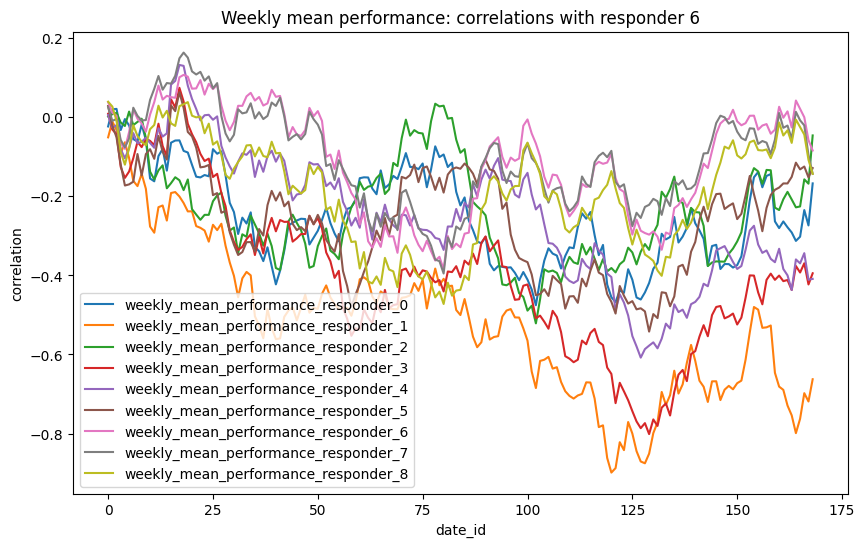

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_mean_performance_responder_{i}'], label=f'weekly_mean_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly mean performance: correlations with responder 6')
ax.legend()
plt.show()

In [ ]:
responders = responders.sort(['date_id', 'time_id', 'symbol_id'])
responders.head(3)

shape: (3, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 171     ┆ 0       ┆ 0         ┆ 0.773821   ┆ … ┆ -0.535104  ┆ -0.044332  ┆ -0.039061 ┆ -0.744789 │
│ 171     ┆ 0       ┆ 1         ┆ 0.799407   ┆ … ┆ -1.417509  ┆ 0.08584    ┆ 0.487232  ┆ -0.124533 │
│ 171     ┆ 0       ┆ 2         ┆ -0.965601  ┆ … ┆ -5.0       ┆ 1.5834     ┆ 0.018712  ┆ -1.055035 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [32]:
features = [f'responder_{i}_lag_daily' for i in range(9)] + [f'total_responder_{i}' for i in range(9)] + [f'mean_responder_{i}' for i in range(9)]
target = 'responder_6'
daily_corr = responders.group_by(['date_id']).agg(
    pl.corr(f, target).name.keep() for f in features
).with_columns(
    #Flip sign for negative mean correlation since we only care about magnitude
    pl.all().exclude('date_id').mul(pl.all().exclude('date_id').mean().sign()).name.keep()
).sort('date_id')
daily_corr

shape: (169, 28)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ responder_ ┆ responder ┆ responder ┆ … ┆ mean_resp ┆ mean_resp ┆ mean_resp ┆ mean_resp │
│ ---     ┆ 0_lag_dail ┆ _1_lag_da ┆ _2_lag_da ┆   ┆ onder_5   ┆ onder_6   ┆ onder_7   ┆ onder_8   │
│ i16     ┆ y          ┆ ily       ┆ ily       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 171     ┆ 0.006742   ┆ 0.027183  ┆ 0.003557  ┆ … ┆ -0.00393  ┆ -0.045172 ┆ -0.045771 ┆ -0.048941 │
│ 172     ┆ -0.023045  ┆ -0.010208 ┆ 0.004022  ┆ … ┆ -0.06343  ┆ -0.021369 ┆ 0.020646  ┆ -0.013809 │
│ 173     ┆ 0.034914   ┆ -0.010938 ┆ 0.005175  ┆ … ┆ 0.036628  ┆ 0.042035  ┆ 0.004018  ┆ 0.055503  │
│ 174     ┆ -0.024395  ┆ 0.04496   ┆ 0.009406  ┆ … ┆ 0.052152  ┆ 0.075316  ┆ 0.072136  ┆ 0.083211  │
│ 175     ┆ -0.009211  ┆ -0.029547 ┆ 0.013499  ┆ … ┆ -0.027169 ┆ -0.029404 ┆ -0.01377  ┆ -0.028869 │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 335     ┆ 0.02149    ┆ -0.004309 ┆ 0.006014  ┆ … ┆ -0.04511  ┆ -0.074791 ┆ -0.071315 ┆ -0.065639 │
│ 336     ┆ -0.037128  ┆ -0.034851 ┆ 0.016457  ┆ … ┆ 0.00631   ┆ 0.010164  ┆ 0.004212  ┆ 0.007747  │
│ 337     ┆ -0.007414  ┆ -0.016032 ┆ 0.017974  ┆ … ┆ -0.053523 ┆ -0.000292 ┆ -0.012606 ┆ -0.003476 │
│ 338     ┆ 0.034006   ┆ -0.063444 ┆ -0.013756 ┆ … ┆ 0.035327  ┆ 0.072797  ┆ 0.090261  ┆ 0.061826  │
│ 339     ┆ -0.030976  ┆ -0.013128 ┆ 0.022586  ┆ … ┆ 0.014739  ┆ 0.046409  ┆ 0.049166  ┆ 0.041617  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [33]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = daily_corr['date_id'].unique().sort().to_list()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()

    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

per_era_corr = daily_corr.to_pandas().set_index('date_id')
# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in features
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=features)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

mean       std    sharpe  max_drawdown     delta
responder_7_lag_daily  0.007727  0.044329  0.174303     -0.312931  0.006308
responder_6_lag_daily  0.007677  0.037710  0.203577     -0.203895  0.009401
total_responder_1      0.005226  0.039060  0.133786     -0.395121  0.002845
mean_responder_1       0.005226  0.039060  0.133786     -0.395121  0.002845
mean_responder_7       0.004950  0.045034  0.109915     -0.362306  0.007791
total_responder_7      0.004950  0.045034  0.109915     -0.362306  0.007791
responder_3_lag_daily  0.004704  0.033279  0.141342     -0.132533  0.004608
responder_1_lag_daily  0.004574  0.035116  0.130252     -0.275986  0.008605
total_responder_8      0.004385  0.044019  0.099611     -0.490817  0.011077
mean_responder_8       0.004385  0.044019  0.099611     -0.490817  0.011077
mean_responder_4       0.003910  0.044505  0.087849     -0.347073  0.002373
total_responder_4      0.003910  0.044505  0.087849     -0.347073  0.002373
responder_8_lag_daily  0.003324  0.019298  0.172269     -0.107361  0.002581
total_responder_6      0.003082  0.043984  0.070075     -0.506028  0.009160
mean_responder_6       0.003082  0.043984  0.070075     -0.506028  0.009160
mean_responder_0       0.003035  0.036499  0.083149     -0.362938  0.001339
total_responder_0      0.003035  0.036499  0.083149     -0.362938  0.001339
responder_5_lag_daily  0.002940  0.019557  0.150357     -0.103597  0.000646
responder_4_lag_daily  0.002858  0.039648  0.072085     -0.400048  0.001510
mean_responder_3       0.001922  0.045932  0.041849     -0.463787  0.005609
total_responder_3      0.001922  0.045932  0.041849     -0.463787  0.005609
mean_responder_5       0.001400  0.043420  0.032237     -0.368683  0.004299
total_responder_5      0.001400  0.043420  0.032237     -0.368683  0.004299
mean_responder_2       0.001036  0.035409  0.029254     -0.383573  0.000024
total_responder_2      0.001036  0.035409  0.029254     -0.383573  0.000024
responder_0_lag_daily  0.000602  0.021266  0.028312     -0.279319  0.003888
responder_2_lag_daily  0.000326  0.010203  0.031997     -0.153443  0.002118

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

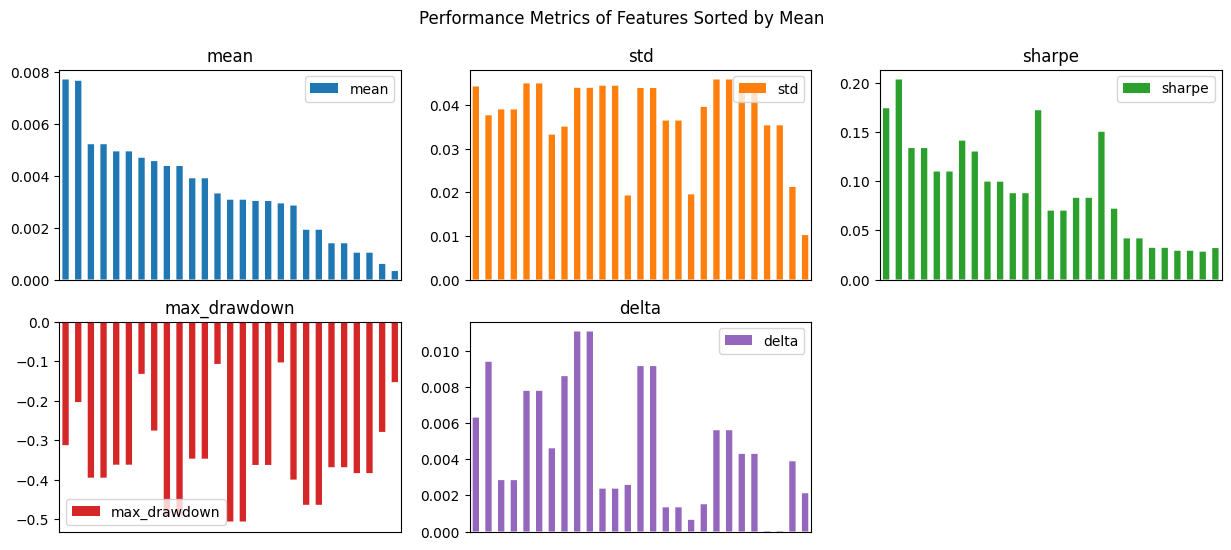

In [34]:
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

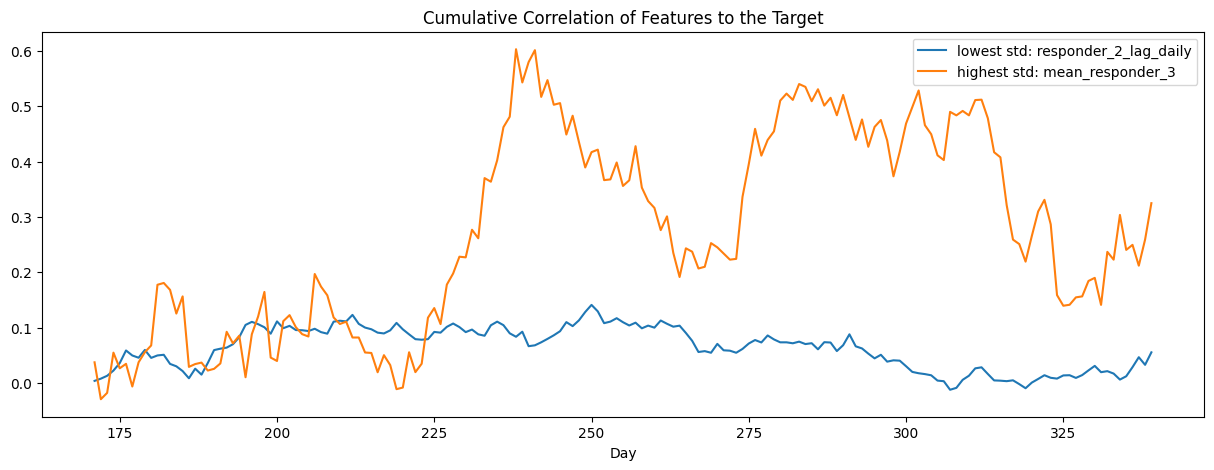

In [35]:
metric="std"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

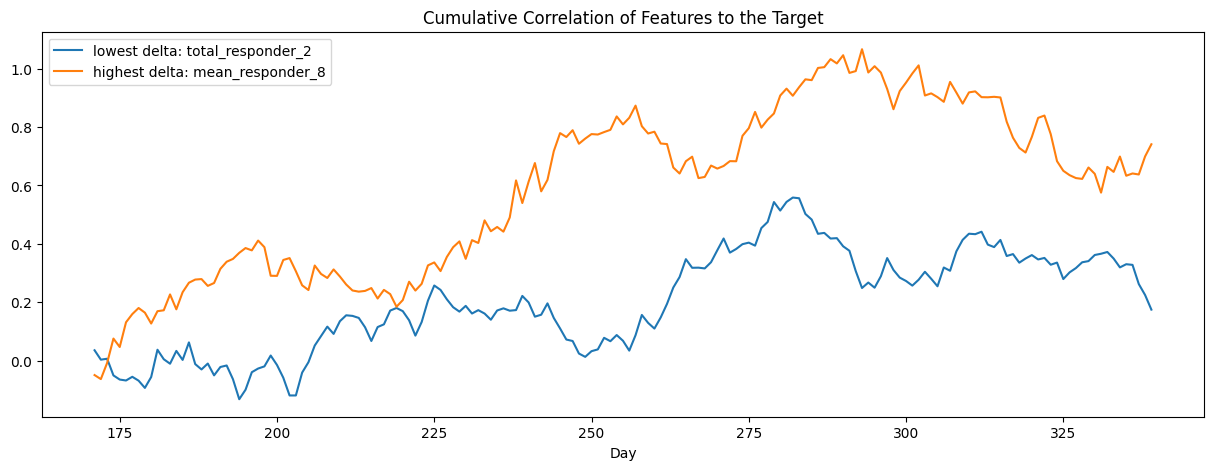

In [36]:
metric="delta"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

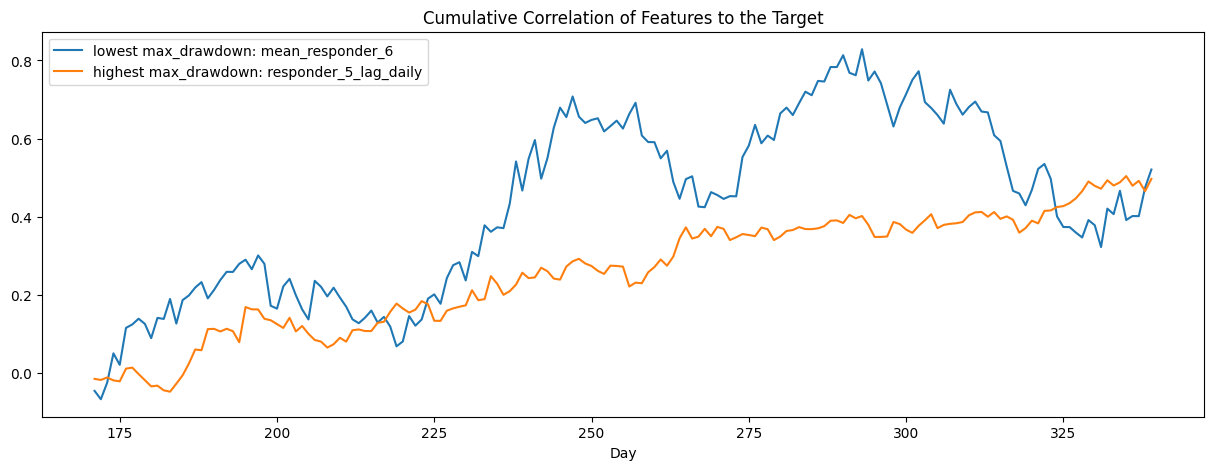

In [37]:
metric="max_drawdown"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])